# Comparing Ketamine and Midazolam after treatment in ROIs
- Analysis in HPC
- focus on end of treatment
- Amygdala
- vmPFC
- Hippocampus

#### Small explanation for the code for future reference (as it is a bit messy)
- I take all functional files of trauma vs relaxed first script first 1min
- I mask for amygdala - run analysis per session (1,2,3) and calculate effect (using pyMC3)
- I mask for vmPFC and do the same
- I mask for hippocampus and do the same
- Effect reported are amygdala and hippocampus show sig. difference in the post treatment scan. Amygdala shows effect in 30 days f/u hipocampus doesn't. vmPFC and OFC doesn't show anything.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import relevant packages
import glob
import numpy as np
import scipy
import nilearn
import nilearn.image
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az
from pymc3.glm import GLM

In [3]:
# in case we want frequency stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
# Set session
ses = 2
## Grab group
# compare between groups

medication_cond = pd.read_csv('/home/oad4/ketamine_reconsolidation/kpe_sub_condition.csv')

func_files = glob.glob('/gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses%s/modelfit/_subject_id_*/modelestimate/results/zstat8.nii.gz' %(ses))

func_files.sort()
len(func_files)

26

In [5]:
# remove 1315
del func_files[6] #(only session 1,2)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


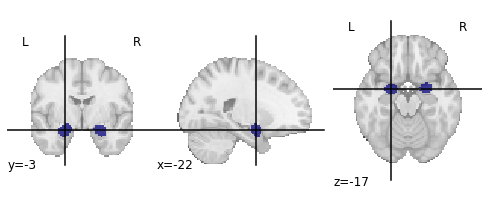

In [6]:
## Amygdala as mask
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=25", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)


masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                                smoothing_fwhm=None, standardize=False,
                                        detrend=False, verbose=9).fit()

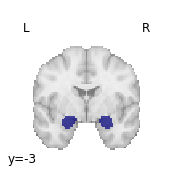

In [9]:
nilearn.plotting.plot_roi(mask_file, draw_cross=False, display_mode='y', cut_coords = [-3])
plt.savefig('amygdala_mask.png', dpi=600)

In [7]:
t_arr = []
mean_act = []
scr_id = []
#delayed_get_data = dask.delayed(masker.fit_transform)
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.transform(func)
    t_arr.append(np.mean(t_map, axis=1)[0])
    


[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. 

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data 

## generate images of amygdala

In [8]:
t_arr.shape

AttributeError: 'list' object has no attribute 'shape'

In [59]:
df_ses3 = []
df_ses3 = pd.DataFrame({'scr_id': scr_id, 'amg3': t_arr})
df_ses3 = pd.merge(medication_cond, df_ses3)
df_ses3 = df_ses3.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df_ses3 = df_ses3.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [69]:
df_ses4 = []
df_ses4 = pd.DataFrame({'scr_id': scr_id, 'amg4': t_arr})
df_ses4 = pd.merge(medication_cond, df_ses4)
df_ses4 = df_ses4.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df_ses4 = df_ses4.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [25]:
df_ses3.groupby('group').describe(percentiles=[.025, 0.975])
#df_ses3.groupby('group').median()

amg3                                                              \
          count      mean       std       min      2.5%       50%     97.5%   
group                                                                         
ketamine   12.0  0.040381  0.215948 -0.327927 -0.300443  0.048336  0.354487   
midazolam  10.0 -0.007256  0.248683 -0.315066 -0.298323 -0.033856  0.432773   

                     
                max  
group                
ketamine   0.373464  
midazolam  0.487722

In [49]:
df_ses2 = []
df_ses2 = pd.DataFrame({'scr_id': scr_id, 'amg2': t_arr})
df_ses2 = pd.merge(medication_cond, df_ses2)
df_ses2 = df_ses2.rename(columns={'med_cond': 'group'})
#df['goup'] = medication_cond['med_cond']
df_ses2 = df_ses2.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [10]:
df_ses2.groupby('group').describe(percentiles=[.025, 0.975])
#df_ses2.groupby('group').median()

amg2                                                              \
          count      mean       std       min      2.5%       50%     97.5%   
group                                                                         
ketamine   13.0 -0.212636  0.364048 -0.864766 -0.856892 -0.194828  0.299733   
midazolam  12.0  0.074769  0.303304 -0.441469 -0.391804  0.079434  0.646030   

                     
                max  
group                
ketamine   0.327870  
midazolam  0.692484

Ttest_indResult(statistic=-2.134378004379769, pvalue=0.04369402222628631)

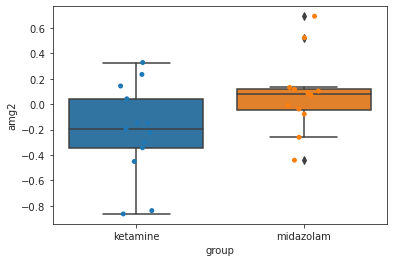

In [11]:
sns.set_style("ticks")
sns.boxplot('group','amg2',data=df_ses2)
sns.stripplot('group','amg2',data=df_ses2)
scipy.stats.ttest_ind(df_ses2.amg2[df_ses2.group=='ketamine'],
                      df_ses2.amg2[df_ses2.group=='midazolam']
                     )

In [38]:
df_ses1 = []
df_ses1 = pd.DataFrame({'scr_id': scr_id, 'amg1': t_arr})
df_ses1 = pd.merge(medication_cond, df_ses1)
df_ses1 = df_ses1.rename(columns={'med_cond': 'group'})
df_ses1 = df_ses1.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})
#df['group'] = medication_cond['med_cond']

In [16]:

df_ses1.groupby('group').describe(percentiles=[.025, 0.975])

amg1                                                              \
          count      mean       std       min      2.5%       50%     97.5%   
group                                                                         
ketamine   13.0 -0.144728  0.335428 -0.854080 -0.796135 -0.102985  0.309516   
midazolam  13.0 -0.011629  0.343508 -0.566561 -0.510175 -0.040662  0.649763   

                     
                max  
group                
ketamine   0.354817  
midazolam  0.736429

In [ ]:
df_ses1

In [ ]:
df_ses1 = pd.merge(df, df_ses1)
df_ses1['amg_change'] = df_ses1.meanAct - df_ses1.amg1

<AxesSubplot:xlabel='group', ylabel='amg1'>

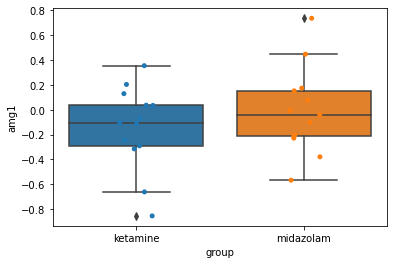

In [45]:
# this is in case we need to show the lowering of amygdala reactivation before and after treatment
sns.boxplot(y='amg1', x= 'group', data = df_ses1)
sns.stripplot(y='amg1', x= 'group', data = df_ses1)

In [ ]:
df_ses3 = pd.merge(df, df_ses3)
df_ses3

Ttest_indResult(statistic=-2.062609757774782, pvalue=0.05237872563020665)

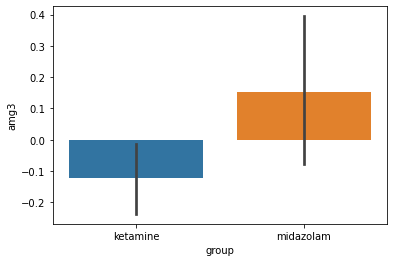

In [46]:
sns.barplot(x='group',y='amg3', data=df_ses3, ci=95)
#sns.boxplot(x='group',y='meanAct', data=df)
scipy.stats.ttest_ind(df_ses3.amg3[df_ses3['group']=='ketamine'], 
                      df_ses3['amg3'][df_ses3['group']=='midazolam'])

In [ ]:
df_ses1 = []
df_ses1 = pd.DataFrame({'scr_id': scr_id, 'meanAct_ses1': average[0]})
df_ses1 = pd.merge(medication_cond, df_ses1)
df_ses1 = df_ses1.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df_ses1 = df_ses1.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [22]:
group = {'ketamine': 1,'midazolam': 0} 
df_ses3['groupIdx'] =[group[item] for item in df_ses3.group] 

In [ ]:
df = []
df = pd.DataFrame({'scr_id': scr_id, 'meanAct': t_arr})
df = pd.merge(medication_cond, df)
df = df.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df = df.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

## Combine all three sessions

In [76]:
df = pd.merge(df_ses1, df_ses2, how='left')
df = pd.merge(df, df_ses3, how='left') # adding that to avoid removing Nan subjects
df = pd.merge(df, df_ses4, how='left')
# add index for group (0 and 1)
group = {'ketamine': 1,'midazolam': 0} 
df['groupIdx'] =[group[item] for item in df.group] 
# save the dataframe
df.to_csv('fourSessions_TraumaVsSad_NewSubs.csv', index = False)

In [21]:
df.groupby(['group']).describe()

amg1                                                              \
          count      mean       std       min       25%       50%       75%   
group                                                                         
ketamine   13.0 -0.144613  0.334908 -0.852853 -0.290200 -0.102914  0.036722   
midazolam  13.0 -0.011599  0.343011 -0.565505 -0.213264 -0.040620  0.152084   

                     amg2            ...      amg4           groupIdx       \
                max count      mean  ...       75%       max    count mean   
group                                ...                                     
ketamine   0.353823  13.0 -0.212322  ...  0.147901  0.224445     13.0  1.0   
midazolam  0.735502  12.0  0.074581  ...  0.116181  0.535162     13.0  0.0   

                                         
           std  min  25%  50%  75%  max  
group                                    
ketamine   0.0  1.0  1.0  1.0  1.0  1.0  
midazolam  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 40 columns]

In [49]:
df.describe()

,amg1,amg2,amg3,groupIdx
count,26.000000,25.000000,22.000000,26.000000
mean,-0.078179,-0.074682,0.002205,0.500000
std,0.339486,0.360424,0.332572,0.509902
min,-0.854080,-0.864766,-0.574087,0.000000
25%,-0.239000,-0.260869,-0.202147,0.000000
50%,-0.083131,-0.038927,-0.005249,0.500000
75%,0.116457,0.117809,0.155408,1.000000
max,0.736429,0.692484,0.808830,1.000000


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.953978,13.080284,two-sided,0.072426,"[-0.58, 0.03]",0.883157,1.415,0.501336


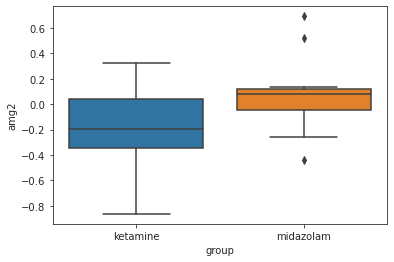

In [30]:
# plot
#sns.barplot(x='group',y='amg2', data=df, ci=95)
sns.boxplot(x='group',y='amg2', data=df)
#scipy.stats.ttest_ind(df.amg2[df['group']==1], df['amg2'][df['group']==0])
pg.ttest(df.amg2[df.group=='ketamine'], df.amg2[df.group=='midazolam'])

## Use PyMC3 for bayesian based analysis 

In [58]:
# first code new variable for group index (1=ketamine, 0= midazolam)
group = {'ketamine': 1,'midazolam': 0} 
df['groupIdx'] =[group[item] for item in df.group] 

In [ ]:
# play with glm module of pymc3
with pm.Model() as model_glm:
    GLM.from_formula('amg2 ~ groupIdx', df)
    trace = pm.sample(draws=5000, tune=3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Selection: 1


In [37]:
az.summary(trace, hdi_prob=.94).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.08,0.10,-0.14,0.26,0.0,0.0,9816.0,10529.0,1.0
groupIdx,-0.29,0.14,-0.55,-0.00,0.0,0.0,9806.0,10682.0,1.0
sd,0.36,0.06,0.26,0.46,0.0,0.0,8323.0,6239.0,1.0


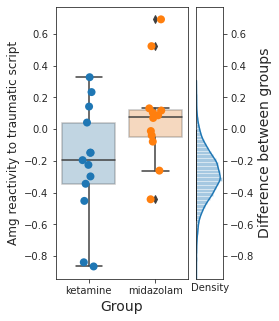

In [39]:
# set variables
sns.set_style("ticks") # set style
y = 'amg2'
dfPlot = df
ci = np.quantile(trace.posterior.groupIdx, [.025,.975])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                        'wspace':.1})
g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
            boxprops=dict(alpha=.3))
g2 = sns.distplot(trace.posterior['groupIdx'], ax = ax2, vertical=True)
ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
           linewidth = 2, linestyle = "-")

#g3.set_ylim(-.7, .7)
#ax1.set_ylim(-.7,.7)
ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
ax2.yaxis.tick_right()
ax2.set_xticks([])
ax2.set_ylabel("Difference between groups", fontsize=14) 
ax2.yaxis.set_label_position("right")
ax1.set_ylabel("Amg reactivity to traumatic script", fontsize=12)
ax1.set_xlabel("Group", fontsize=14)
fig.savefig('amygdalaReactivity.png', dpi=600, bbox_inches='tight')

### Creating mixed level model

In [53]:
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg1','amg2','amg3'])
#df_long.to_csv('amygdala.csv', index=False)

In [54]:
df_long

,scr_id,groupIdx,variable,value
0,KPE008,1,amg1,0.203813
1,KPE1223,1,amg1,-0.102985
2,KPE1253,0,amg1,-0.100468
3,KPE1263,0,amg1,-0.378608
4,KPE1293,1,amg1,-0.290477
...,...,...,...,...
73,KPE1561,0,amg3,0.102168
74,KPE1573,1,amg3,0.004843
75,KPE1578,0,amg3,-0.494568
76,KPE1587,1,amg3,NaN


In [56]:
## Try to use statsmodel
model = pymer4.Lmer('value ~ groupIdx + variable + (1|scr_id)', data=df_long)
results = model.fit()

RRuntimeError: Error in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]) : 
  there is no package called ‘Matrix’


In [41]:
with pm.Model() as model_glm1:
    GLM.from_formula('value ~ groupIdx + variable', df_long)
    trace_mixed = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, variable[T.amg3], variable[T.amg2], Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


In [42]:
az.summary(trace_mixed)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.035,0.079,-0.112,0.187,0.001,0.001,4705.0,4981.0,1.0
variable[T.amg2],0.009,0.096,-0.170,0.194,0.001,0.001,5141.0,5092.0,1.0
variable[T.amg3],0.092,0.100,-0.087,0.286,0.001,0.001,5404.0,5097.0,1.0
groupIdx,-0.228,0.081,-0.374,-0.072,0.001,0.001,6341.0,5203.0,1.0
sd,0.333,0.029,0.280,0.388,0.000,0.000,6449.0,4596.0,1.0


#### There is a main effect for the group (ketamine lower than midazolam)

## Next we do the same for vmPFC

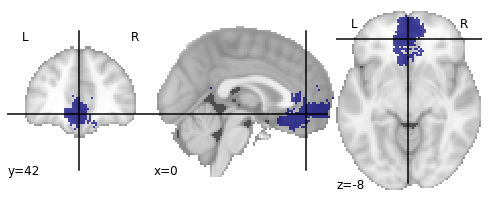

In [70]:
# now lets do the same with vmPFC
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=5", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None,
                                        standardize=False, detrend=False, verbose=5)

In [71]:
mean_act_vmpfc = []
scr_id = []
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.fit_transform(func)
    
    average = np.mean(np.array(t_map))
    mean_act_vmpfc.append(average)


[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_si

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_s

In [ ]:
#df["vmpfc2"] = mean_act_vmpfc
df_vmpfc = pd.DataFrame({'scr_id': scr_id, 'vmpfc2': mean_act_vmpfc})
df = pd.merge(df, df_vmpfc, how='left')
#df_vmpfc = pd.merge(df_vmpfc, medication_cond)
sns.boxplot(x='group',y='vmpfc2', data=df)
#sns.barplot(x='med_cond',y='meanAct', data=df_vmpfc, ci=68)
scipy.stats.ttest_ind(df.vmpfc2[df['group']=='ketamine'],
                      df.vmpfc2[df['group']=='midazolam'])

In [62]:
df_ses3['vmpfc3'] = mean_act_vmpfc

In [72]:
df_ses4['vmpfc4'] = mean_act_vmpfc

In [52]:
df_ses2['vmpfc2'] = mean_act_vmpfc

In [41]:
df_ses1['vmpfc1'] = mean_act_vmpfc

In [53]:
df[['vmpfc1', 'vmpfc2','vmpfc3','group']].groupby(['group']).describe()


vmpfc1                                                              \
           count      mean       std       min       25%       50%       75%   
group                                                                          
ketamine    13.0  0.178070  0.393307 -0.338212 -0.103086  0.051453  0.418075   
midazolam   13.0  0.219586  0.244825 -0.378535  0.096373  0.286975  0.393598   

                    vmpfc2            ...                     vmpfc3  \
                max  count      mean  ...       75%       max  count   
group                                 ...                              
ketamine   0.966591   13.0  0.029428  ...  0.377307  0.655051   12.0   
midazolam  0.458108   12.0  0.096880  ...  0.291235  0.526451   10.0   

                                                                       \
               mean       std       min       25%       50%       75%   
group                                                                   
ketamine  -0.019311  0.410531 -0.729120 -0.315079  0.005527  0.305256   
midazolam  0.023814  0.301336 -0.482464 -0.163449  0.062645  0.198823   

                     
                max  
group                
ketamine   0.527678  
midazolam  0.443480  

[2 rows x 24 columns]

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('vmPFC ~ groupIdx', df)
    trace_vmpfc = pm.sample(draws=4000, tune=3000)

In [ ]:
pm.summary(trace_vmpfc, credible_interval=.95).round(2)

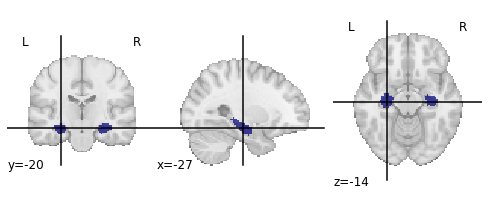

In [10]:
## Hippocampus
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=15", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None,
                                        standardize=False, detrend=False, verbose=5)

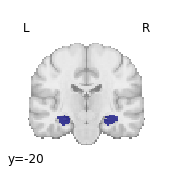

In [11]:
nilearn.plotting.plot_roi(mask_file, draw_cross=False, display_mode='y', cut_coords = [-20])
plt.savefig('hippocampus_mask.png', dpi=600)

In [74]:
mean_act_hippo = []
scr_id = []
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.fit_transform(func)
    
    average = np.mean(np.array(t_map))
    mean_act_hippo.append(average)


[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_si

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_s

In [65]:
df_ses3['hippo3'] = mean_act_hippo

In [75]:
df_ses4['hippo4'] = mean_act_hippo

In [72]:
df_ses3.groupby('group').describe()

amg3                                                              \
          count      mean       std       min       25%       50%       75%   
group                                                                         
ketamine   12.0  0.040381  0.215948 -0.327927 -0.096792  0.048336  0.204520   
midazolam  10.0 -0.007256  0.248683 -0.315066 -0.196494 -0.033856  0.128106   

                    vmpfc3            ...                     hippo3  \
                max  count      mean  ...       75%       max  count   
group                                 ...                              
ketamine   0.373464   12.0 -0.019311  ...  0.305256  0.527678   12.0   
midazolam  0.487722   10.0  0.023814  ...  0.198823  0.443480   10.0   

                                                                       \
               mean       std       min       25%       50%       75%   
group                                                                   
ketamine  -0.043276  0.283836 -0.544535 -0.264493  0.014883  0.188368   
midazolam -0.012912  0.224512 -0.330583 -0.202816 -0.037441  0.166482   

                     
                max  
group                
ketamine   0.370235  
midazolam  0.344957  

[2 rows x 24 columns]

In [55]:
df_ses2['hippo2'] = mean_act_hippo

In [44]:
df_ses1['hippo1'] = mean_act_hippo

Ttest_indResult(statistic=1.1472356287714416, pvalue=0.26307856236693034)

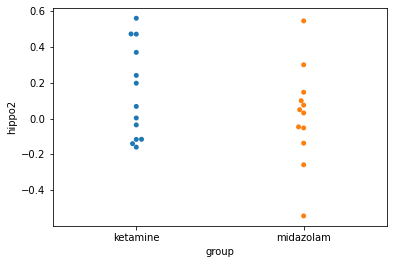

In [80]:
sns.swarmplot(x='group',y='hippo2', data=df_ses2)
scipy.stats.ttest_ind(df_ses2.hippo2[df_ses2['group']=='ketamine'],
                      df_ses2['hippo2'][df_ses2['group']=='midazolam'])

In [ ]:
df['hippo_21'] = df.hippo2 - df.hippo1
sns.barplot(x='group',y='hippo_21', data=df, ci=68)
scipy.stats.ttest_ind(df.hippo_21[df['group']=='ketamine'], df['hippo_21'][df['group']=='midazolam'])

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('hippo2 ~ groupIdx', df)
    trace_hippo = pm.sample(draws=2000, tune=2000,random_seed=103)
az.summary(trace_hippo, hdi_prob=.95).round(2)

In [ ]:
trace_hippo.groupIdx

In [ ]:
# set variables
sns.set_style("ticks")
y = 'hippo2'
dfPlot = df
ci = np.quantile(trace_hippo.groupIdx, [.025,.975])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                        'wspace':.1})
g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
            boxprops=dict(alpha=.3))
g2 = sns.distplot(trace_hippo['groupIdx'], ax = ax2, vertical=True)
ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
           linewidth = 2, linestyle = "-")


ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
ax2.yaxis.tick_right()
ax2.set_xticks([])
ax2.set_ylabel("Difference between groups", fontsize=14) 
ax2.yaxis.set_label_position("right")
ax1.set_ylabel("Hippocampus reactivity to traumatic script", fontsize=12)
ax1.set_xlabel("Group", fontsize=14)
fig.savefig('hippoReactivity.png', dpi=600, bbox_inches='tight')

In [ ]:
df.groupby('group').describe()

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('hippo3 ~ groupIdx', df)
    trace_hippo = pm.sample(draws=2000, tune=2000,random_seed=103)
az.summary(trace_hippo, hdi_prob=.95).round(2)

## Running mixed level models

In [43]:
df_longAmg = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg1','amg2','amg3'])
df_longAmg

,scr_id,groupIdx,variable,value
0,KPE008,1,amg1,0.203813
1,KPE1223,1,amg1,-0.102985
2,KPE1253,0,amg1,-0.100468
3,KPE1263,0,amg1,-0.378608
4,KPE1293,1,amg1,-0.290477
...,...,...,...,...
73,KPE1561,0,amg3,0.102168
74,KPE1573,1,amg3,0.004843
75,KPE1578,0,amg3,-0.494568
76,KPE1587,1,amg3,NaN


In [44]:
df_longAmg['scr_id'] = df_longAmg.scr_id.astype('category')
sub_idx = df_longAmg.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
# set y observerd

#print(data.pcl)
n_subs = len(np.unique(df_longAmg.scr_id))
print(n_subs)
# set time as index also
# set only three categories (after, 1month, 3months)
df_longAmg.variable = pd.Categorical(df_longAmg.variable, 
                    categories=['amg1','amg2','amg3'])
timeIDX = df_longAmg.variable.cat.codes.values
print(timeIDX)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [45]:
df_longAmg.describe()

,groupIdx,value
count,78.000000,73.000000
mean,0.500000,-0.052756
std,0.503236,0.341910
min,0.000000,-0.864766
25%,0.000000,-0.242438
50%,0.500000,-0.038927
75%,1.000000,0.129702
max,1.000000,0.808830


<AxesSubplot:xlabel='amg2', ylabel='Count'>

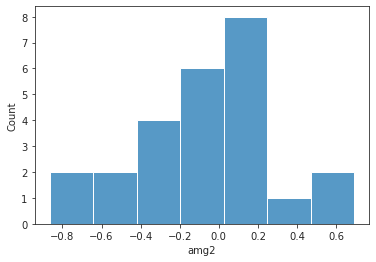

In [47]:
sns.histplot(df['amg2'])

In [48]:
with pm.Model() as multilevel_real:
    # Hyperpriors for group nodes
    #mu_a = pm.Normal('mu_a', mu=0.1, sigma=0.1)
    mu_b = pm.Normal('mu_b', mu=0, sd=0.1)
 
    
    a = pm.Normal('a', mu=0.2, sd=0.1, shape=n_subs)
       
    b = pm.Normal('b', mu=mu_b, sd=0.1, shape=3)
    #inter = pm.Normal('inter', mu=0, sd=1) # modeling interaction for each treatment
    
    bMed = pm.Normal('bMed', mu=0, sd=1.5)#, shape=2)
    #bMed = pm.Binomial('bMed', n=n_subs, p=0.5)#, mu=0, sd=0.3)
  
    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX]*timeIDX + bMed*df_longAmg.groupIdx# + inter*timeIDX*df_longAmg.groupIdx

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_longAmg.value)
    real_trace = pm.sample(4000, tune=2000, target_accept=.9, return_inferencedata=True, random_seed=112)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, b, a, mu_b]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 13 seconds.


In [49]:
az.summary(real_trace,  hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b,-0.026,0.064,-0.129,0.080,0.001,0.000,11143.0,11775.0,1.0
a[0],0.247,0.088,0.101,0.390,0.001,0.000,18569.0,12503.0,1.0
a[1],0.186,0.088,0.039,0.327,0.001,0.000,21313.0,12681.0,1.0
a[2],0.162,0.091,0.015,0.314,0.001,0.001,16930.0,12455.0,1.0
a[3],0.183,0.088,0.038,0.328,0.001,0.000,20735.0,11985.0,1.0
a[4],0.196,0.088,0.050,0.340,0.001,0.000,18745.0,12078.0,1.0
a[5],0.137,0.089,-0.002,0.288,0.001,0.001,18029.0,12456.0,1.0
a[6],0.198,0.089,0.050,0.342,0.001,0.000,20392.0,12936.0,1.0
a[7],0.175,0.088,0.028,0.315,0.001,0.000,21856.0,11547.0,1.0
a[8],0.098,0.091,-0.050,0.245,0.001,0.001,17501.0,11758.0,1.0


In [50]:
md2 = smf.mixedlm("value ~ variable + groupIdx", df_longAmg, groups=df_longAmg["scr_id"], 
                  missing='drop', re_formula='~variable')
mdf2 = md2.fit()
print(mdf2.summary())

                      Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          value   
No. Observations:           73               Method:                      REML    
No. Groups:                 26               Scale:                       0.0485  
Min. group size:            2                Log-Likelihood:              -22.9080
Max. group size:            3                Converged:                   Yes     
Mean group size:            2.8                                                   
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                0.029    0.081  0.363 0.717 -0.130  0.188
variable[T.amg2]                         0.002    0.070  0.024 0.981 -0.136  0.140
variable[T.amg3]           

In [51]:
aov = pg.mixed_anova(data=df_longAmg, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     1.130      1     19  1.130  6.177    0.022  0.245  nan
variable     0.208      2     38  0.104  1.305    0.283  0.064    0.921
Interaction  0.138      2     38  0.069  0.862    0.430  0.043  nan



### Same test for hippocampus

In [ ]:
df_longHippo = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['hippo1','hippo2','hippo3'])


In [ ]:
with pm.Model() as multilevel_realHippo:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=30, sigma=10)
    mu_b = pm.Normal('mu_b', mu=0, sigma=10)
    
  #  med_mu = pm.Normal('mu_med', mu=0, sigma=15)
    
    a = pm.Normal('a', mu=mu_a, sd=10, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sigma=10, shape=3)
    #inter = pm.Normal('inter', mu=0, sd=10) # modeling interaction for each treatment
    
    bMed = pm.Normal('bMed', mu=0, sd=10)
  
    # Model error
    eps = pm.HalfCauchy('eps', 10)

    y_hat = a[sub_idx] + b*df_longHippo.variable + bMed*df_longHippo.groupIdx# + inter*timeIDX*df_longAmg.groupIdx

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_longHippo.value)
    trace_hippo = pm.sample(4000, tune=2000, target_accept=.9, return_inferencedata=True)

In [ ]:
az.summary(trace_hippo,  hdi_prob=.95)

In [ ]:
aov_hippo = pg.mixed_anova(data=df_longHippo, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov_hippo)

## Stats with Dabest

In [61]:
import dabest

<module 'dabest' from '/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/dabest/__init__.py'>

In [73]:
df

,scr_id,group,amg1,amg2,amg3,groupIdx
0,KPE008,ketamine,0.203813,0.042115,-0.122106,1
1,KPE1223,ketamine,-0.102985,-0.343700,-0.214441,1
2,KPE1253,midazolam,-0.100468,-0.011433,NaN,0
3,KPE1263,midazolam,-0.378608,0.117809,0.550700,0
4,KPE1293,ketamine,-0.290477,-0.147948,-0.088285,1
5,KPE1307,ketamine,-0.854080,-0.451648,0.019811,1
6,KPE1322,ketamine,-0.065793,0.142954,-0.574087,1
7,KPE1339,ketamine,-0.314558,-0.147956,-0.342517,1
8,KPE1343,ketamine,-0.660930,-0.838521,-0.284087,1
9,KPE1351,midazolam,-0.213582,-0.260869,0.390324,0


In [88]:
dbDf = dabest.load(df, idx=('midazolam', 'ketamine'), x='group', y='amg2', resamples=10000)

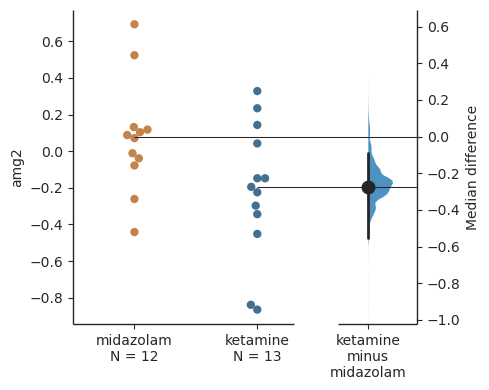

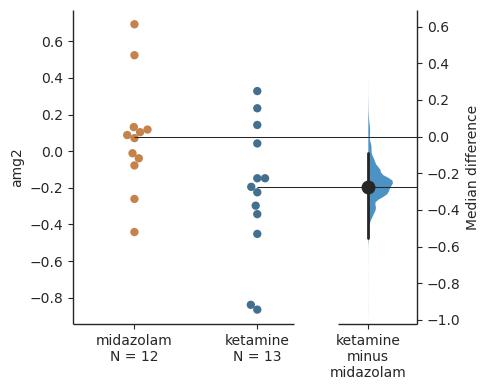

In [91]:
dbDf.median_diff.plot()